In [21]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [22]:
FEATURE_PATH = "../dataset/processed"
X = np.load(f"{FEATURE_PATH}/X_hog.npy")  # or X_lbp.npy / X_color.npy
y = np.load(f"{FEATURE_PATH}/y.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2856, 6354)
y shape: (2856,)


In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Training samples: 2284
Validation samples: 572


In [34]:
svm_model = SVC(
    kernel='rbf',
    probability=True,
    C=20,
    gamma='scale',
    random_state=42
)

# Train
svm_model.fit(X_train_scaled, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",20
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [35]:
y_pred = svm_model.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", acc)

Validation Accuracy: 0.75


In [36]:
import os

# Path to your dataset (augmented or processed images)
DATASET_PATH = "../dataset/augmented"

# Define classes by listing subfolders, excluding 'unknown'
CLASSES = sorted([
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d)) and d != 'unknown'
])

print("Classes:", CLASSES)

print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=[str(c) for c in CLASSES]))



Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.70      0.80      0.75        95
       glass       0.71      0.79      0.75        95
       metal       0.77      0.61      0.68        95
       paper       0.77      0.78      0.77        96
     plastic       0.74      0.66      0.70        96
       trash       0.82      0.86      0.84        95

    accuracy                           0.75       572
   macro avg       0.75      0.75      0.75       572
weighted avg       0.75      0.75      0.75       572



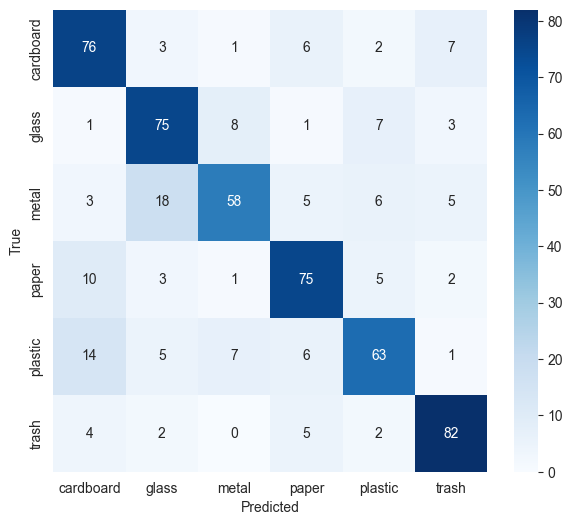

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [38]:
import joblib

# Save SVM model
MODEL_PATH = "../models/svm_best.pkl"
joblib.dump(svm_model, MODEL_PATH)
print("SVM model saved at:", MODEL_PATH)


SVM model saved at: ../models/svm_best.pkl


In [41]:

# Load model
svm_model = joblib.load(MODEL_PATH)

print("SVM model loaded successfully")
print(svm_model)


SVM model loaded successfully
SVC(C=20, probability=True, random_state=42)


In [40]:
threshold = 0.6

probs = svm_model.predict_proba(X_val_scaled)
max_probs = probs.max(axis=1)

y_pred_with_unknown = []
for pred, mp in zip(svm_model.predict(X_val_scaled), max_probs):
    if mp < threshold:
        y_pred_with_unknown.append(6)  # unknown
    else:
        y_pred_with_unknown.append(pred)
